In [2]:
import torch
import torch.nn as nn
import dataset_util as util
import pathlib
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torch.utils.data import DataLoader,random_split
from torchtext.vocab import build_vocab_from_iterator
from transformer import Transformer
import matplotlib.pyplot as plt

/home/mil/yoshikawa/.pyenv/versions/anaconda3-2023.03/envs/machine_translation/lib/python3.10/site-packages/torchtext/transforms.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mil/yoshikawa/.pyenv/versions/anaconda3-2023.03/envs/machine_translation/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/mil/yoshika

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
print("--- Retrieve Data ---")
FILE_PATH = './dataset/deu-eng/deu.txt'

data_pipe = dp.iter.IterableWrapper([FILE_PATH])
data_pipe = dp.iter.FileOpener(data_pipe,mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines=0,delimiter='\t',as_tuple=True)

data_pipe = data_pipe.map(util.removeAttribution)

eng = spacy.load('en_core_web_sm')
de = spacy.load('de_core_news_sm')

--- Retrieve Data ---


In [6]:
print('--- Build Vocaburaries ---')
source_vocab = build_vocab_from_iterator(
    util.getTokens(data_pipe,0,eng.tokenizer,de.tokenizer),
    min_freq=2,
    specials=['<pad>','<sos>','<eos>','<unk>'],
    special_first=True
)
source_vocab.set_default_index(source_vocab['<unk>'])

--- Build Vocaburaries ---


In [7]:
target_vocab = build_vocab_from_iterator(
    util.getTokens(data_pipe,1,eng.tokenizer,de.tokenizer),
    min_freq=2,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

In [8]:
target_vocab.set_default_index(target_vocab['<unk>'])

In [9]:
print('--- Transform Data : Adding SOS and EOS ---')
def applyTransform(sequence_pair):
    return (
        util.getTransform(source_vocab)(util.Tokenize(sequence_pair[0],eng.tokenizer)),
        util.getTransform(target_vocab)(util.Tokenize(sequence_pair[1],de.tokenizer))
    )

data_pipe = data_pipe.map(applyTransform)

data_pipe = util.separateSourceTarget(data_pipe)

--- Transform Data : Adding SOS and EOS ---


In [10]:
print('--- Apply Padding ---')
src_pad = util.applyPadding(data_pipe[0],device)
tgt_pad = util.applyPadding(data_pipe[1],device)

dataset = []
for i in range(len(src_pad)):
    dataset.append((src_pad[i],tgt_pad[i]))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset,test_dataset = random_split(dataset,[train_size,test_size])

data_loader = DataLoader(dataset,batch_size=64,shuffle=True)
test_data_loader = DataLoader(dataset,batch_size=64)

--- Apply Padding ---


In [14]:
### Training Loop ###
print('--- Training ---')
src_vocab_size = 13610
tgt_vocab_size = 24266
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 128
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout,device)

epochs = 5

loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(transformer.parameters(),lr = 0.0001,betas=(0.9,0.98),eps=1e-9)

transformer.train()

steps = []
loss_plots = []

total_loss = 0


--- Training ---


In [11]:
def evaluatemodel(model, source_input,start_token,end_token,max_seq_length):
    target_input = [start_token]
    for _ in range(max_seq_length):
        pred = model(source_input,torch.tensor(target_input).unsqueeze(0).to(device)).squeeze(0)
        next_token = torch.argmax(pred[-1],dim=-1).item()
        target_input.append(next_token)
        if next_token == end_token:
            break
    return target_input

In [26]:

target_index_to_string = target_vocab.get_itos()
source_index_to_string = source_vocab.get_itos()

In [28]:
with torch.inference_mode():
    for batch, (source, target) in enumerate(test_data_loader):
        print(source.shape)
        source = source.to(device)
        target = target.to(device)
        output = transformer(source, target[:,:-1])
        loss = loss = loss_fn(output.contiguous().view(-1,tgt_vocab_size),target[:,1:].contiguous().view(-1))
        print(loss.item())
        total_loss += loss.item()

        if batch % 100 == 0:
            sentence = ''
            for i in source[0].cpu().numpy():
                sentence += ' ' + source_index_to_string[i]
            print(sentence)
            source_sentence = source[0].unsqueeze(0)
            print(source_sentence.shape)
            target_index = evaluatemodel(transformer,source_sentence,start_token=1,end_token=2,max_seq_length=max_seq_length)
            sentence = ''
            for index in target_index:
                sentence += ' ' + target_index_to_string[index]
            print(sentence) 
        break

loss_avg = total_loss / len(test_data_loader)
print(loss_avg)

torch.Size([64, 113])
10.34080982208252
 <sos> Go . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
torch.Size([1, 113])


 <sos> Strumpfhosen Fünfen empfindlich Mützen rosige rosige rosige überredete weichen rosige Kirschbaum tätig Antrag Teppichen Japaner altern Enthusiasmus anstecken ziemliches Pfeil holprig Sibirien vorspielte wettet rennen rosige Tragwerk Eisenbahn 140 Herzrasen Werd Immer Tat altern Ruhm Drehtür Schwarzmarkt Rat überreicht erzählst Augenklappe bereute Dachten Immer Tat Sehkraft offenbart bereute allzubald allzubald fortgeschrittenen verwöhnte Nichten betrinken Ruhm Künstler Korrespondent rausbekommen Korrespondent Zaume Wolltet Strumpfhosen Tatsächlich siebentausend Augenbinde Korrespondent Maschine Schwarzmarkt Welcher pleite Korrespondent Tatsächlich Loch konzentrierte Kamm bezüglich Riss schlägt Unterrichtsmethoden wägen Weihnachtsfilm 155 begehen eingebildet Kirschbaum hinkte Wolltet Privatvergnügen einzigartig was fegt verwöhnte applaudierten Stativ zuknöpfen öffnen beibringen zuknöpfen öffnen zugesehen allzubald Experte Städtchen bestehe gefälschten Führt zusätzlich Atheist Aug

In [13]:
len(data_loader)

4343

In [15]:
X,y = next(iter(data_loader))

In [16]:
X.shape

torch.Size([64, 113])

In [17]:
y.shape

torch.Size([64, 90])

In [18]:
source = X.to(device)
target = y.to(device)

In [19]:
output = transformer(source,target[:,:-1])

In [20]:
output.shape

torch.Size([64, 89, 24266])

In [22]:
output = output.contiguous().view(-1,tgt_vocab_size)

In [23]:
output.shape

torch.Size([5696, 24266])

In [25]:
for epoch in range(epochs):
    print('--- New Epoch Starts ---')
    for batch,(source,target) in enumerate(data_loader):
        optimizer.zero_grad()
        source = source.to(device)
        target = target.to(device)
        output = transformer(source,target[:,:-1])
        loss = loss_fn(output.contiguous().view(-1,tgt_vocab_size),target[:,1:].contiguous().view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if (epoch * len(data_loader) + batch) % 200 == 0:
            steps.append(epoch * len(data_loader) + batch)
            loss_plots.append(loss)
            print('loss',loss,end='r')

--- New Epoch Starts ---
loss tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward0>)r

loss tensor(2.1087, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.2680, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.0165, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.5006, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.7090, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.0214, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.1789, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.7376, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.8636, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.6835, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(2.0011, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.4699, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.4746, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.7946, device='cuda:0', grad_fn=<NllLossBackward0>)rloss tensor(1.8868, devic

KeyboardInterrupt: 

In [ ]:
transformer.eval()
total_loss = 0

target_index_to_string = target_vocab.get_itos()
source_index_to_string = source_vocab.get_itos()

with torch.inference_mode():
    for batch, (soruce, target) in enumerate(test_data_loader):
        source = source.to(device)
        target = target.to(device)
        output = transformer(source, target[:,:-1])
        loss = loss = loss_fn(output.contiguous().view(-1,tgt_vocab_size),target[:,1:].contiguous().view(-1))
        total_loss += loss.item()

        if batch % 100 == 0:
            source_sentence = source[0]
            target_index = evaluatemodel(transformer,source,start_token=1,end_token=2)
            sentence = ''
            for index in target_index:
                sentence += ' ' + target_index_to_string[index]
            print(sentence) 

loss_avg = total_loss / len(test_data_loader)
print(loss_avg)

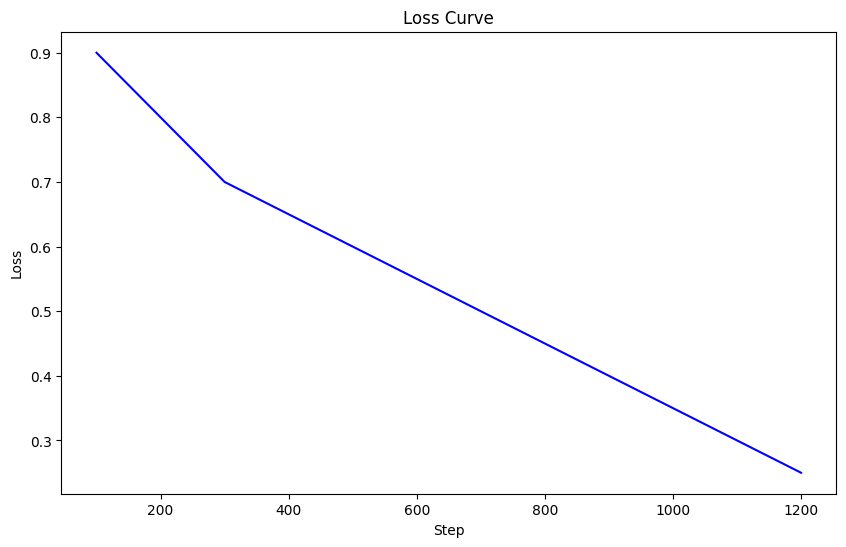

: 

In [34]:
import matplotlib.pyplot as plt

def plot_loss_curve(steps, losses, title='Loss Curve', xlabel='Step', ylabel='Loss', save_path=None):
    """
    Plots a loss curve given a list of steps and loss values, and optionally saves the plot to a file.
    
    Parameters:
    steps (list of int): List of step values for the x-axis.
    losses (list of float): List of loss values for the y-axis.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    save_path (str): If provided, the path where the plot will be saved.
    """
    # Check if the inputs are valid lists of integers and floats
    if not all(isinstance(x, int) for x in steps):
        raise ValueError("All elements in the steps list must be integers.")
    if not all(isinstance(x, (int, float)) for x in losses):
        raise ValueError("All elements in the losses list must be floats or ints.")
    if len(steps) != len(losses):
        raise ValueError("The steps and losses lists must have the same length.")
    
    # Plot the loss values
    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, linestyle='-', color='b')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot
    plt.show()

# Example usage
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
losses = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25]
plot_loss_curve(steps, losses, save_path='loss_curve.png')
